# 长短期记忆网络

构件：

- 输入门：和候选记忆元一起更新 记忆元
- 遗忘门：更新 记忆元
- 输出门：和 记忆元 一起更新 隐状态

输出由隐状态计算得出

In [1]:
import re
import math
import collections
import random
import torch
from torch import nn
import d2l_torch as d2l
from torch.nn import functional as F

In [2]:
# 读取数据集
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

In [3]:
# 词元的类型是字符串，而模型需要的输入是数字
# 构建一个词典，叫做词表，用来将字符串类型的词元映射到从 0 开始的数字索引中
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 未知词元的索引为 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [4]:
# 词元化
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('error: unknown type ' + token)

In [5]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)

    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [6]:
# 随机采样策略
def seq_data_iter_random(corpus, batch_size, num_steps):
    # 随机偏移
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 子序列的数量
    num_subseqs = (len(corpus) - 1) // num_steps
    # 子序列启始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos+num_steps]

    # 批量数 = 子序列数 / 批量大小
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        # 下一个时间步的内容作为模型的标号
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [7]:
# 顺序分区策略
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps - 1)
    # 每个batch内的相邻子序列是顺序的
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    # 每个batch内的序列数
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:,i:i+num_steps]
        Y = Ys[:,i:i+num_steps]
        yield X, Y

In [8]:
# # 偷偷输出一个迭代轮次看看
# my_iter = seq_data_iter_sequential(corpus, batch_size=32, num_steps=35)
# vocab_size = len(vocab)
# for X, Y in my_iter:
#     print('X:', X)
#     print('Y:', Y)
#     X_ont_hot = F.one_hot(X.T, vocab_size).type(torch.float32)
#     Y_reshape = Y.T.reshape(-1)
#     print('X one_hot:', X_ont_hot)
#     print('Y.T.reshape(-1):', Y_reshape)
#     print(X.shape, Y.shape, X_ont_hot.shape, Y_reshape.shape)
#     break

In [9]:
# 整合两个采样函数
class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [10]:
# 加载数据
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [11]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [12]:
# 初始化模型参数
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )

    W_xi, W_hi, b_i = three()  # 输入门
    W_xf, W_hf, b_f = three()  # 遗忘门
    W_xo, W_ho, b_o = three()  # 输出门
    W_xc, W_hc, b_c = three()  # 候选记忆元

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
             b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [13]:
# 定义模型
def init_lstm_state(batch_size, num_hiddens, device):
    return (
        torch.zeros((batch_size, num_hiddens), device=device),
        torch.zeros((batch_size, num_hiddens), device=device)
    )

In [14]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
    W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [15]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device,
                get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [16]:
# 预测
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [17]:
# 梯度裁剪
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [18]:
# 训练
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    # flag = 1
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        # if flag == 1:
        #     print(y_hat.shape, y.long().shape)
        #     flag = 0
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

使用 loss(outputs, targets) 计算 loss，其中 outputs 的形状是 (1120, 28)，targets 的形状为 (1120). 1120 是样本数，28 是类别数。

In [19]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
             use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                           legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))            

困惑度 1.1, 27719.7 词元/秒 cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


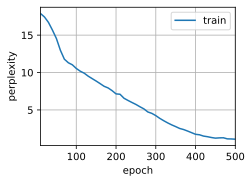

In [20]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                       init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [21]:
# 偷偷看一下预测时 net 输出的 y 的生数据长什么样
prefix = 'time traveller'
num_preds = 50
num_hiddens=256
device=d2l.try_gpu()
net = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                      init_lstm_state, lstm)
state = net.begin_state(batch_size=1, device=device)
outputs = [vocab[prefix[0]]]
get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
for y in prefix[1:]:
    _, state = net(get_input(), state)
    outputs.append(vocab[y])
for _ in range(num_preds):
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))
    print('y:', y)
    print('y.shape:', y.shape)
    print('y.argmax(dim=1):', y.argmax(dim=1))
    print('vocab.idx_to_token[int(y.argmax(dim=1).reshape(1))]:', vocab.idx_to_token[int(y.argmax(dim=1).reshape(1))])
    print('state[0].shape:', state[0].shape)
    print('state[1].shape:', state[1].shape)
    print('outputs:', outputs)
    break
''.join([vocab.idx_to_token[i] for i in outputs])

y: tensor([[ 1.5925e-04,  2.7491e-04, -1.1740e-04, -2.3342e-04,  2.5531e-04,
         -5.1765e-04,  8.3273e-04,  4.1091e-04, -8.9757e-04, -1.7769e-04,
         -4.9066e-04,  4.0781e-04, -1.4975e-03, -3.8261e-04, -8.1693e-04,
         -1.6436e-04, -6.2350e-04, -2.5908e-04,  6.8487e-05, -4.9634e-04,
         -1.7748e-04,  6.4176e-05,  5.8591e-04,  3.9165e-04, -1.0967e-04,
         -2.7626e-04,  7.6972e-05, -8.6826e-04]], grad_fn=<CatBackward0>)
y.shape: torch.Size([1, 28])
y.argmax(dim=1): tensor([6])
vocab.idx_to_token[int(y.argmax(dim=1).reshape(1))]: n
state[0].shape: torch.Size([1, 256])
state[1].shape: torch.Size([1, 256])
outputs: [3, 5, 13, 2, 1, 3, 10, 4, 22, 2, 12, 12, 2, 10, 6]


'time travellern'